In [224]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation,BatchNormalization,Input,Embedding,Dot,Dense,Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

from wordcloud import WordCloud

%matplotlib inline


In [225]:
# ! pip install matplotlib wordcloud

### Reading animelist.csv

In [226]:
INPUT_DIR = os.path.join("..","artifacts/raw/")
df_animelist = pd.read_csv(INPUT_DIR + "animelist.csv",low_memory=True,
                           usecols = ["user_id","anime_id","rating"])
df_animelist.head(2)

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7


In [227]:
df_animelist.shape, df_animelist.columns

((5000000, 3), Index(['user_id', 'anime_id', 'rating'], dtype='object'))

### Data Processing

In [228]:
df_rating = df_animelist['user_id'].value_counts()

In [229]:
df_rating = df_rating[df_rating >=400]
df_rating.index

Index([11100, 10255,  4773,  6852, 16057, 10409, 15609, 10665,  6536,  4132,
       ...
        8812,  5375, 11167,  4776, 10675,  5660,  8213, 11932,  4529,  4125],
      dtype='int64', name='user_id', length=4203)

In [230]:
df_animelist["user_to_keep"] = df_animelist['user_id'].apply(lambda i: True  if i in df_rating.index else False )
df_rating = df_animelist[df_animelist["user_to_keep"]==True]
df_rating.head(2)

,user_id,anime_id,rating,user_to_keep
213,2,24833,0,True
214,2,235,10,True


In [231]:
min_rating =  min(df_rating['rating'])
max_rating = max(df_rating['rating'])
average_rating = df_rating['rating'].mean()
min_rating, max_rating, average_rating

(0, 10, np.float64(4.122732695114736))

In [232]:
# min-max scaling
df_rating['rating'] = df_rating['rating'].apply(lambda i: (i- min_rating)/(max_rating-min_rating))
df_rating

C:\Users\HP omen\AppData\Local\Temp\ipykernel_2556\856503923.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rating['rating'] = df_rating['rating'].apply(lambda i: (i- min_rating)/(max_rating-min_rating))


,user_id,anime_id,rating,user_to_keep
213,2,24833,0.0,True
214,2,235,1.0,True
215,2,36721,0.0,True
216,2,40956,0.0,True
217,2,31933,0.0,True
...,...,...,...,...
4999916,16507,8985,0.0,True
4999917,16507,5454,0.0,True
4999918,16507,15911,0.0,True
4999919,16507,878,0.0,True


In [233]:
df_rating['rating'].mean()

np.float64(0.4122732695114736)

In [234]:
# Checking for duplicates and null values
df_rating.duplicated().sum() , df_rating.isnull().sum()

(np.int64(0),
 user_id         0
 anime_id        0
 rating          0
 user_to_keep    0
 dtype: int64)

In [235]:
user_id = df_rating["user_id"].unique().tolist()
user_id_encoded = {id: encode  for encode,id in enumerate(user_id)}
user_id_decoded = {decode: id  for decode,id in enumerate(user_id)}
len(user_id_encoded),len(user_id_decoded)

(4203, 4203)

In [236]:
user_id_decoded[0],user_id_encoded[214]

(2, 46)

In [237]:
df_rating["user_id_encoded"]= df_rating["user_id"].apply(lambda i :user_id_encoded[i] )
df_rating

C:\Users\HP omen\AppData\Local\Temp\ipykernel_2556\3091495491.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rating["user_id_encoded"]= df_rating["user_id"].apply(lambda i :user_id_encoded[i] )


,user_id,anime_id,rating,user_to_keep,user_id_encoded
213,2,24833,0.0,True,0
214,2,235,1.0,True,0
215,2,36721,0.0,True,0
216,2,40956,0.0,True,0
217,2,31933,0.0,True,0
...,...,...,...,...,...
4999916,16507,8985,0.0,True,4202
4999917,16507,5454,0.0,True,4202
4999918,16507,15911,0.0,True,4202
4999919,16507,878,0.0,True,4202


In [238]:
anime_id = df_rating["anime_id"].unique().tolist()
anime_id_encoded = {id: encode  for encode,id in enumerate(anime_id)}
anime_id_decoded = {decode: id  for decode,id in enumerate(anime_id)}
len(anime_id_encoded),len(anime_id_decoded)

(17149, 17149)

In [239]:
df_rating["anime_id_encoded"]= df_rating["anime_id"].apply(lambda i :anime_id_encoded[i] )
df_rating.drop(columns ="user_to_keep",inplace=True)

C:\Users\HP omen\AppData\Local\Temp\ipykernel_2556\506289636.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rating["anime_id_encoded"]= df_rating["anime_id"].apply(lambda i :anime_id_encoded[i] )
C:\Users\HP omen\AppData\Local\Temp\ipykernel_2556\506289636.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rating.drop(columns ="user_to_keep",inplace=True)


In [240]:
df_rating

,user_id,anime_id,rating,user_id_encoded,anime_id_encoded
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4
...,...,...,...,...,...
4999916,16507,8985,0.0,4202,2533
4999917,16507,5454,0.0,4202,817
4999918,16507,15911,0.0,4202,2455
4999919,16507,878,0.0,4202,2154


In [241]:
df_rating=df_rating.sample(frac=1,random_state=43).reset_index(drop=True)

In [242]:
x = df_rating[['user_id_encoded','anime_id_encoded']]
y = df_rating[['rating']]
x.shape, y.shape

((3246641, 2), (3246641, 1))

In [243]:
train_test_split = 0.01
total_size = len(x)
train_size = int((1-train_test_split)*total_size)
x_train = x[:train_size]
y_train = y[:train_size]
x_test = x[train_size:]
y_test = y[train_size:]
x_train.shape,y_train.shape,x_test.shape,y_test.shape

((3214174, 2), (3214174, 1), (32467, 2), (32467, 1))

In [244]:
x_train_list = [x_train.iloc[:,0],x_train.iloc[:,1]]
x_test_list = [x_test.iloc[:,0],x_test.iloc[:,1]]

## MODEL ARCHITECTURE

In [245]:

num_users = len(user_id_encoded)
num_animes = len(anime_id_encoded)
def RecommenderSystem():
    embedding_size = 128

    user = Input(name='user',shape=[1])
    user_embedding = Embedding(name="user_embedding",input_dim=num_users,output_dim=embedding_size)(user)

    anime = Input(name='anime',shape=[1])
    anime_embedding = Embedding(name="anime_embedding",input_dim=num_animes,output_dim=embedding_size)(anime)

    x = Dot(name='dot_product',normalize=True,axes=2)([user_embedding,anime_embedding])
    x = Flatten()(x)
    x = Dense(1,kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation("sigmoid")(x)

    model = Model(inputs=[user,anime], outputs=x)
    model.compile(loss = "binary_crossentropy",
                  metrics = ["mae","mse"],
                   optimizer ='Adam' )
    return model

model = RecommenderSystem()

In [246]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    537,984 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_8 (Flatten) │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │          2 │ flatten_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ dense_8[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_8        │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,733,062 (10.43 MB)

 Trainable params: 2,733,060 (10.43 MB)

 Non-trainable params: 2 (8.00 B)

In [247]:
start_lr = 1e-5
min_lr = 1e-4
max_lr = 5e-5
batch_size = 10000
ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch > ramup_epochs:
        return (max_lr-start_lr)/ramup_epochs*epoch + start_lr
    
    elif epoch < ramup_epochs + sustain_epochs:
        return max_lr
    
    else:
        return (max_lr-min_lr)*exp_decay**(epoch-ramup_epochs-sustain_epochs) + min_lr


In [248]:
lr_callback = LearningRateScheduler( lambda epoch: lrfn(epoch), verbose = 0)
checkpoint_filepath = "./weights.weights.h5"
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   save_weights_only =True,
                                   monitor="val_loss",
                                   mode = "min",
                                   save_best_only=True)
early_stopping = EarlyStopping(patience=3 ,# after 3 epochs, no improvement in performance
                                monitor = "val_loss",
                                restore_best_weights = True
                                )               

In [249]:
my_callbacks = [model_checkpoint,lr_callback,early_stopping]

In [250]:
history = model.fit(
    x = x_train_list,
    y = y_train,
    batch_size = batch_size,
    epochs = 20,
    verbose =1,
    validation_data = (x_test_list,y_test),
    callbacks = my_callbacks

)

Epoch 1/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 24s 69ms/step - loss: 0.7665 - mae: 0.3761 - mse: 0.1861 - val_loss: 0.6966 - val_mae: 0.3618 - val_mse: 0.1573 - learning_rate: 5.0000e-05
Epoch 2/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 22s 67ms/step - loss: 0.7524 - mae: 0.3706 - mse: 0.1802 - val_loss: 0.7331 - val_mae: 0.3690 - val_mse: 0.1733 - learning_rate: 5.0000e-05
Epoch 3/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 22s 69ms/step - loss: 0.7381 - mae: 0.3648 - mse: 0.1741 - val_loss: 0.7485 - val_mae: 0.3712 - val_mse: 0.1790 - learning_rate: 5.0000e-05
Epoch 4/20
322/322 ━━━━━━━━━━━━━━━━━━━━ 25s 78ms/step - loss: 0.7220 - mae: 0.3577 - mse: 0.1671 - val_loss: 0.7392 - val_mae: 0.3672 - val_mse: 0.1749 - learning_rate: 5.0000e-05


In [251]:
def extract_weights(name,model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weight()[0]
    weights = weights/np.linalg.norm(weights,axis =1).reshape((-1,1))
    return weights

In [252]:
model.get_weights()[1]

array([[-0.02663577,  0.04885335, -0.00725315, ...,  0.02889797,
        -0.03148261,  0.04636159],
       [ 0.02667227, -0.00489519,  0.0251581 , ..., -0.03082613,
        -0.03318688, -0.04590874],
       [ 0.04487606, -0.01967614, -0.0395462 , ..., -0.04337459,
        -0.00426585,  0.00061924],
       ...,
       [-0.0004993 ,  0.05003963,  0.03928417, ...,  0.0421712 ,
         0.02019289,  0.02724095],
       [ 0.03587635,  0.02629485, -0.03831809, ...,  0.01148015,
        -0.01502246,  0.00534456],
       [ 0.04304472, -0.03608707,  0.0382265 , ...,  0.03543907,
         0.04517904, -0.04684262]], shape=(17149, 128), dtype=float32)

In [253]:
anime_weights = model.get_layer("anime_embedding").get_weights()[0]
user_weights = model.get_layer("user_embedding").get_weights()[0]

#### Working now with ANIME.CSV

In [254]:
df = pd.read_csv(INPUT_DIR+"anime.csv",low_memory=True)
df.shape

(17562, 35)

In [255]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0


In [256]:
df.replace("Unknown",np.nan,inplace=True)

In [257]:
df["anime_id"] = df["MAL_ID"]
df["eng_version"] = df["English name"]
def getAmineName(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]

        return name
    
    except:
        print("Error")

df["eng_version" ] = df.anime_id.apply( lambda id :getAmineName(id))
df

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",NaN,...,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0,5,Cowboy Bebop:The Movie
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0,6,Trigun
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, Magic",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0,7,Witch Hunter Robin
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0,8,Beet the Vandel Buster
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,盗墓笔记之秦岭神树,ONA,NaN,"Apr 4, 2021 to ?",NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,48481,Daomu Biji Zhi Qinling Shen Shu
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,見える子ちゃん,TV,NaN,2021 to ?,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48483,Mieruko-chan
17559,48488,Higurashi no Naku Koro ni Sotsu,NaN,"Mystery, Dementia, Horror, Psychological, Supernatural, Thriller",Higurashi:When They Cry – SOTSU,ひぐらしのなく頃に卒,TV,NaN,"Jul, 2021 to ?",Summer 2021,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48488,Higurashi:When They Cry – SOTSU
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,ヤマノススメ Next Summit,TV,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,48491,Yama no Susume: Next Summit


In [258]:
df.sort_values(by = ["Score"],
               inplace=True,
               ascending=False,
               kind = 'quicksort',
               na_position = 'last')

In [259]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [260]:
df = df [["anime_id","eng_version","Score","Genres",
          "Episodes","Type","Premiered","Members"]]
df

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",24,TV,Spring 2011,1771162
14963,38524,Attack on Titan Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Shounen, Super Power",10,TV,Spring 2019,1073626
9913,28977,Gintama Season 4,9.1,"Action, Comedy, Historical, Parody, Samurai, Sci-Fi, Shounen",51,TV,Spring 2015,404121
...,...,...,...,...,...,...,...,...
17557,48481,Daomu Biji Zhi Qinling Shen Shu,NaN,"Adventure, Mystery, Supernatural",NaN,ONA,NaN,354
17558,48483,Mieruko-chan,NaN,"Comedy, Horror, Supernatural",NaN,TV,NaN,7010
17559,48488,Higurashi:When They Cry – SOTSU,NaN,"Mystery, Dementia, Horror, Psychological, Supernatural, Thriller",NaN,TV,Summer 2021,11309
17560,48491,Yama no Susume: Next Summit,NaN,"Adventure, Slice of Life, Comedy",NaN,TV,NaN,1386


In [261]:
def getAnimeFrame(anime,df):
    if isinstance(anime,int):
        return df[df.anime_id ==anime]
    
    else:
        return df[df.eng_version ==anime]

In [262]:
getAnimeFrame(40028,df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


In [263]:
getAnimeFrame("Attack on Titan Final Season",df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
15926,40028,Attack on Titan Final Season,9.17,"Action, Military, Mystery, Super Power, Drama, Fantasy, Shounen",16,TV,Winter 2021,733260


### Working with ANIME_SYNOPSIS.CSV

In [264]:
cols = ["MAL_ID","Name","Genres","sypnopsis"]
df_synopsis = pd.read_csv(INPUT_DIR+"anime_with_synopsis.csv",
                          usecols=cols)
df_synopsis.head(2)


,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."
1,5,Cowboy Bebop: Tengoku no Tobira,"Action, Drama, Mystery, Sci-Fi, Space","other day, another bounty—such is the life of the often unlucky crew of the Bebop. However, this routine is interrupted when Faye, who is chasing a fairly worthless target on Mars, witnesses an oil tanker suddenly explode, causing mass hysteria. As casualties mount due to a strange disease spreading through the smoke from the blast, a whopping three hundred million woolong price is placed on the head of the supposed perpetrator. With lives at stake and a solution to their money problems in sight, the Bebop crew springs into action. Spike, Jet, Faye, and Edward, followed closely by Ein, split up to pursue different leads across Alba City. Through their individual investigations, they discover a cover-up scheme involving a pharmaceutical company, revealing a plot that reaches much further than the ragtag team of bounty hunters could have realized."


In [285]:
def getSynopsis(anime,df):
    if isinstance(anime,int):
        return df[df.MAL_ID ==anime]['sypnopsis']
    
    else:
        return df[df.Name ==anime]['sypnopsis']
    
getSynopsis(1,df_synopsis),getSynopsis("Cowboy Bebop: Tengoku no Tobira",df_synopsis)

(0    In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as "Cowboys." The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classi

### Content based recommendation system

In [266]:
pd.set_option("max_colwidth",None)

In [267]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen",64,TV,Spring 2009,2248456


In [268]:
df_synopsis.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized several of the planets and moons of the solar system leaving the now uninhabitable surface of planet Earth behind. The Inter Solar System Police attempts to keep peace in the galaxy, aided in part by outlaw bounty hunters, referred to as ""Cowboys."" The ragtag team aboard the spaceship Bebop are two such individuals. Mellow and carefree Spike Spiegel is balanced by his boisterous, pragmatic partner Jet Black as the pair makes a living chasing bounties and collecting rewards. Thrown off course by the addition of new members that they meet in their travels—Ein, a genetically engineered, highly intelligent Welsh Corgi; femme fatale Faye Valentine, an enigmatic trickster with memory loss; and the strange computer whiz kid Edward Wong—the crew embarks on thrilling adventures that unravel each member's dark and mysterious past little by little. Well-balanced with high density action and light-hearted comedy, Cowboy Bebop is a space Western classic and an homage to the smooth and improvised music it is named after."


In [269]:
anime_id_encoded

{24833: 0,
 235: 1,
 36721: 2,
 40956: 3,
 31933: 4,
 5042: 5,
 7593: 6,
 21: 7,
 35446: 8,
 24: 9,
 22: 10,
 38034: 11,
 17251: 12,
 5762: 13,
 31580: 14,
 33253: 15,
 35028: 16,
 9513: 17,
 368: 18,
 11633: 19,
 31964: 20,
 33486: 21,
 31740: 22,
 1470: 23,
 1575: 24,
 2904: 25,
 1535: 26,
 28223: 27,
 226: 28,
 38671: 29,
 32872: 30,
 15: 31,
 71: 32,
 7661: 33,
 245: 34,
 263: 35,
 5258: 36,
 270: 37,
 24703: 38,
 15451: 39,
 8074: 40,
 11061: 41,
 28961: 42,
 34542: 43,
 14719: 44,
 20899: 45,
 26055: 46,
 34933: 47,
 37086: 48,
 1604: 49,
 22535: 50,
 189: 51,
 34599: 52,
 29575: 53,
 10620: 54,
 32182: 55,
 23755: 56,
 20: 57,
 1735: 58,
 35581: 59,
 5040: 60,
 30276: 61,
 34134: 62,
 6893: 63,
 11499: 64,
 29786: 65,
 16498: 66,
 28171: 67,
 32282: 68,
 9253: 69,
 3455: 70,
 22319: 71,
 10851: 72,
 40658: 73,
 29809: 74,
 25397: 75,
 2852: 76,
 1635: 77,
 1636: 78,
 40337: 79,
 39085: 80,
 857: 81,
 9721: 82,
 36625: 83,
 6987: 84,
 8577: 85,
 9849: 86,
 4010: 87,
 16642: 88,
 

In [270]:
anime_weights.shape

(17149, 128)

In [327]:
def find_similar_animes(name,anime_weights,anime_id_encoded,
                        anime_id_decoded,df,df_synopsis,
                        num_recomendations = 10,
                        return_dist = False,
                        neg = False):
    try:
        index = getAnimeFrame(name,df).anime_id.values[0]
        encoded_index = anime_id_encoded.get(index)
        weights = anime_weights

        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)
        # print(sorted_dists)
        # print(np.sort(dists))
        num_recomendations = num_recomendations+1

        if neg:
            closest = sorted_dists[:num_recomendations]

        else:
            closest = np.flip(sorted_dists)[:num_recomendations]

        # print(f"Anime closest to {name}")

        if return_dist:
            return dists, closest
        
        Smilarity_Arr = []
        for close in closest:
            decoded_id = anime_id_decoded.get(close)

            synopsis = getSynopsis(decoded_id,df_synopsis)

            anime_frame = getAnimeFrame(decoded_id,df)

            anime_name = anime_frame.eng_version.values[0]
            # print(f"anime_name : {anime_name}")

            genre = anime_frame.Genres.values[0]
            # print(f"genre: {genre}")
            
            similarity = dists[close]
            # print(f" similarity: {similarity}")
            Smilarity_Arr.append({
                "anime_id": decoded_id,
                "name": anime_name,
                "similarity":similarity,
                "genre": genre,
                "synopsis":synopsis
            })

        df_out = pd.DataFrame(Smilarity_Arr).sort_values(by = "similarity",ascending =False)
        return df_out[df_out.anime_id != index].drop(['anime_id'],axis=1)
    
    except Exception as e:
        print("Error occured: ",e)




In [272]:
find_similar_animes("Two Tea Two",
                    anime_weights,anime_id_encoded,
                    anime_id_decoded,df,df_synopsis,
                    num_recomendations = 5)

[  328  6881  3957 ... 15805 10520  5315]
[-0.03843794 -0.03695331 -0.0357808  ...  0.03479569  0.03653282
  0.11285441]
Anime closest to Two Tea Two


,name,similarity,genre,synopsis
1,Psychedelic Afternoon,0.036533,Music,"8338 Seiji is tormented by horrible tsunami-flashback dreams, but one night he wakes up and his beloved grandfather has appeared. With a strum of his grandfather’s guitar, Seiji is transported to a colorful, slightly strange, psychedelic world and finally manages to have a good dream. (Source: Zapuni.com) Name: sypnopsis, dtype: object"
2,Land,0.034796,"Dementia, Music","14002 Short animation directed by Masanobu Hiraoka. Name: sypnopsis, dtype: object"
3,Anata wa Watashi no Mono,0.033620,Hentai,"Series([], Name: sypnopsis, dtype: object)"
4,Gintama:The Movie,0.033222,"Action, Sci-Fi, Comedy, Historical, Parody, Samurai, Shounen","4333 Gintoki and his Yorozuya friends (or rather, employees suffering under labor violations), Shinpachi and Kagura, continue to scrape by in the futuristic, alien-infested city of Edo. They take on whatever work they can find while trying not to get involved in anything too dangerous. But when Katsura, the leader of the Joui rebels and Gintoki's long-time acquaintance, disappears after being brutally attacked by an unknown assassin, Shinpachi and Kagura begin an investigation into his whereabouts and the identity of the assailant. Meanwhile, Gintoki takes on a seemingly unrelated job: the blacksmith Tetsuya requests that Gin recover a strange and powerful sword called the Benizakura which was recently stolen. As the two investigations gradually intersect, the Yorozuya crew find themselves in the midst of a major conspiracy that hinges on the sinister nature of the Benizakura sword. Gintoki resolves to take the fight directly to the enemy headquarters, and together with a few unexpected allies, sets out on one of his most perilous jobs yet. Name: sypnopsis, dtype: object"
5,Glass Mask:The Girl of a Thousand Masks,0.032532,"Drama, Shoujo","2889 OVA depicting the early events of the Glass no Kamen series. Kitajima Maya is a young girl from a poor background with no talents of use to school or her widowed mother. However, she is obsessed with movies, theatrical plays and TV dramas-to the point of remembering every line from a movie she's seen once, and dramatically acting out the stories, including every character, for anyone who will listen. One day, she encounters an old woman with a scarred face who claims that Maya is the girl she's been looking for-for the old woman has spent years protecting the rights to a 'legendary' play. Name: sypnopsis, dtype: object"


In [273]:
user_weights[1].shape

(128,)

### Collaborative filter: User based Recommendation

In [326]:
def find_similar_users(item_input,
                       user_weights,
                       user_id_encoded,
                       user_id_decoded,
                       num_recommendations = 10,
                       return_dist=False,
                       neg = False):
    try:
        index = item_input
        encoded_index = user_id_encoded.get(index)
        weights = user_weights
        dists = np.dot(weights,weights[encoded_index])
        sorted_dists = np.argsort(dists)
        num_recommendations = num_recommendations+1

        if neg:
            closest = sorted_dists[:num_recommendations]

        else:
            closest = np.flip(sorted_dists)[:num_recommendations]

        # print(f"Animes closest to {item_input}")

        if return_dist:
            return dists, closest
        
        Smilarity_Arr = []
        for close in closest:
            
            similarity = dists[close]
            # print(f" similarity: {similarity}")

            if isinstance(item_input,int):
                decode_id = user_id_decoded.get(close)
                Smilarity_Arr.append({
                    "similar_user":decode_id,
                    "similarity":similarity
                }
                )


        similar_users = pd.DataFrame(Smilarity_Arr).sort_values(by = "similarity",ascending =False)
        return similar_users[similar_users.similar_user != item_input]
    
    except Exception as e:
        print("Error occured: ",e)

In [275]:
find_similar_users(4564,
                    user_weights,
                    user_id_encoded,
                    user_id_decoded,
                    num_recommendations = 10)

Animes closest to 4564


,similar_user,similarity
1,2450,0.029485
2,7436,0.029109
3,9831,0.028094
4,6371,0.027004
5,1397,0.026760
6,1650,0.026641
7,14150,0.025962
8,15583,0.025517
9,15083,0.025093
10,11012,0.024936


In [276]:
def showWordCloud(all_genres):
    genres_cloud = WordCloud(width=700,
                             height=400,
                             background_color='white',
                             colormap='gnuplot'
                             ).generate_from_frequencies(all_genres)
    plt.figure(figsize = (10,8))
    plt.imshow(genres_cloud,interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [277]:
from collections import defaultdict
def getFavGenre(frame,plot=False):
    frame.dropna(inplace=False)
    all_genres = defaultdict(int)
    genres_list = []
    for genres in frame["Genres"]:
        if isinstance(genres,str):
            for genre in genres.split(","):
                genres_list.append(genre)
                all_genres[genre.strip()]+=1
    if plot:
        showWordCloud(all_genres)

    return genres_list

In [278]:
frame1 = getAnimeFrame(1,df)

In [279]:
getFavGenre(frame1,plot=False)

['Action', ' Adventure', ' Comedy', ' Drama', ' Sci-Fi', ' Space']

In [280]:
df_rating

,user_id,anime_id,rating,user_id_encoded,anime_id_encoded
0,457,18153,0.9,120,1377
1,4903,20507,0.7,1195,1216
2,6313,23325,0.0,1591,1239
3,15851,37491,0.0,4024,1813
4,1596,29803,0.9,415,353
...,...,...,...,...,...
3246636,7916,721,1.0,2005,955
3246637,7516,16067,0.0,1898,1398
3246638,12682,28171,0.8,3208,67
3246639,8387,33255,0.7,2114,1595


In [281]:
def get_user_preferences(user_id, rating_df,df,plot=False):
    animes_watched_by_user = rating_df[rating_df.user_id ==user_id]
    user_rating_percentile = np.percentile(animes_watched_by_user.rating,75)
    animes_watched_by_user = animes_watched_by_user[animes_watched_by_user.rating>=user_rating_percentile]
    top_anime_by_user = animes_watched_by_user.sort_values(by = "rating",ascending=False).anime_id.values
    df_anime = df[df["anime_id"].isin(top_anime_by_user)]
    df_anime = df_anime[["eng_version","Genres"]]

    if plot:
        getFavGenre(df_anime,plot)

    return df_anime

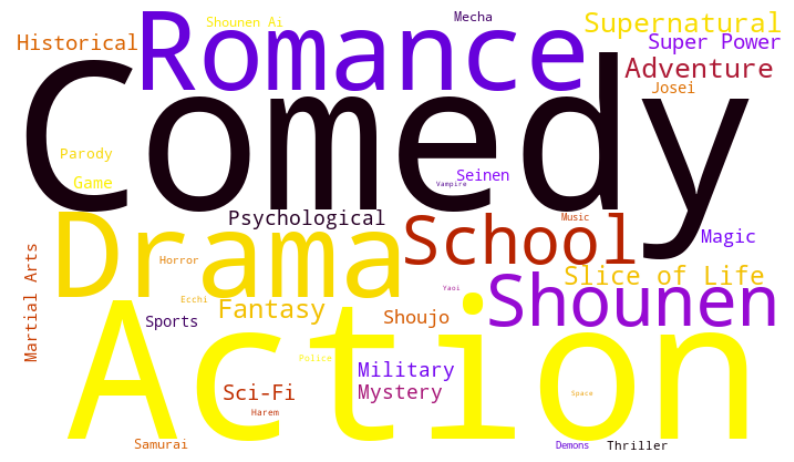

,eng_version,Genres
3971,Fullmetal Alchemist:Brotherhood,"Action, Military, Adventure, Comedy, Drama, Magic, Fantasy, Shounen"
9886,A Silent Voice,"Drama, School, Shounen"
11308,Your Name.,"Romance, Supernatural, School, Drama"
2656,Code Geass:Lelouch of the Rebellion R2,"Action, Military, Sci-Fi, Super Power, Drama, Mecha"
11624,Haikyu!! 3rd Season,"Comedy, Sports, Drama, School, Shounen"
...,...,...
11203,Hakuouki: Otogisoushi,"Fantasy, Historical, Josei, Samurai"
696,Naruto:Find the Crimson Four-leaf Clover!,"Adventure, Comedy, Shounen"
2749,Ginga Eiyuu Densetsu Gaiden: Ougon no Tsubasa,"Action, Military, Sci-Fi, Space, Drama"
10837,"Rainy Cocoa, Welcome to Rainy Color","Slice of Life, Comedy"


In [282]:
get_user_preferences(4564,df_rating,df,plot=True)


In [312]:
def user_recommendation(similar_users,
                        user_pref,
                        df,
                        df_synopsis,
                        df_rating,
                        num_recommendations = 10
                        ):
    recommended_animes = []
    anime_list = []

    for user_id in similar_users.similar_user.values:
        pref_list = get_user_preferences(user_id,df_rating,df)
        pref_list = pref_list[~pref_list.eng_version.isin(user_pref.eng_version.values)]

        if not pref_list.empty:
            anime_list.append(pref_list.eng_version.values)
        
    if anime_list:
        df_anime = pd.DataFrame(anime_list)
        sorted_list = pd.DataFrame(pd.Series(df_anime.values.ravel()).value_counts()).head(num_recommendations)
        for i,anime_name in enumerate(sorted_list.index):
            n_user_pref = sorted_list[sorted_list.index ==anime_name].values[0][0]

            if isinstance(anime_name,str):
                anime_frame = getAnimeFrame(anime_name,df)
                anime_id = anime_frame.anime_id.values[0]
                # print(anime_id)
                genre = anime_frame.Genres.values[0]
                synopsis = getSynopsis(int(anime_id),df_synopsis)
                recommended_animes.append({
                        "num_users_liked":n_user_pref,
                        "anime_name":anime_name,
                        "genre":genre,
                        "synopsis":synopsis
                })

    return pd.DataFrame(recommended_animes).head(num_recommendations)
        


In [313]:
similar_users = find_similar_users(4564,
                    user_weights,
                    user_id_encoded,
                    user_id_decoded,
                    num_recommendations = 10)
user_pref = get_user_preferences(4564,df_rating,df)
user_recommendation(similar_users,
                        user_pref,
                        df,
                        df_synopsis,
                        df_rating)

Animes closest to 4564


,num_users_liked,anime_name,genre,synopsis
0,16,GATE,"Action, Military, Adventure, Fantasy","9956 Several months have passed since the infamous Ginza Incident, with tensions between the Empire and JSDF escalating in the vast and mysterious ""Special Region"" over peace negotiations. The greed and curiosity of the global powers have also begun to grow, as reports about the technological limitations of the magical realm's archaic civilizations come to light. Meanwhile, Lieutenant Youji Itami and his merry band of female admirers struggle to navigate the complex political intrigue that plagues the Empire's court. Despite her best efforts, Princess Piña Co Lada faces difficulties attempting to convince her father that the JSDF has no intention of conquering their kingdom. Pressured from both sides of the Gate, Itami must consider even more drastic measures to fulfill his mission. Name: sypnopsis, dtype: object"
1,9,Nisekoi:False Love,"Harem, Comedy, Romance, School, Shounen","7049 aku Ichijou, a first-year student at Bonyari High School, is the sole heir to an intimidating yakuza family. Ten years ago, Raku made a promise to his childhood friend. Now, all he has to go on is a pendant with a lock, which can only be unlocked with the key which the girl took with her when they parted. Now, years later, Raku has grown into a typical teenager, and all he wants is to remain as uninvolved in his yakuza background as possible while spending his school days alongside his middle school crush Kosaki Onodera. However, when the American Bee Hive Gang invades his family's turf, Raku's idyllic romantic dreams are sent for a toss as he is dragged into a frustrating conflict: Raku is to pretend that he is in a romantic relationship with Chitoge Kirisaki, the beautiful daughter of the Bee Hive's chief, so as to reduce the friction between the two groups. Unfortunately, reality could not be farther from this whopping lie—Raku and Chitoge fall in hate at first sight, as the girl is convinced he is a pathetic pushover, and in Raku's eyes, Chitoge is about as attractive as a savage gorilla. Nisekoi follows the daily antics of this mismatched couple who have been forced to get along for the sake of maintaining the city's peace. With many more girls popping up his life, all involved with Raku's past somehow, his search for the girl who holds his heart and his promise leads him in more unexpected directions than he expects. Name: sypnopsis, dtype: object"
2,8,Aldnoah.Zero,"Action, Military, Sci-Fi, Mecha","7790 The discovery of a hypergate on the Moon once allowed the human race to teleport to Mars. Those who chose to settle there unearthed a technology far more advanced than that of their home planet, which they named ""Aldnoah."" This discovery led to the founding of the Vers Empire of Mars and a declaration of war against the ""Terrans,"" those who stayed behind on Earth. However, a battle on the moon—later called ""Heaven's Fall""—caused the hypergate to explode, destroying the moon and leading the two planets to establish an uneasy ceasefire. Their peace was a fragile one, however. Fifteen years later, high school student Inaho Kaizuka witnesses the plotted assassination of the Vers Empire's Princess Asseylum Vers Allusia, who had come to Earth in hopes of repairing the relationship between the empire and its homeland. The ceasefire is shattered, and the Martians declare war on the Terrans once again. In the face of this insurmountable enemy, Inaho and his friends must now fight against the Vers Empire to settle the war once and for all. Name: sypnopsis, dtype: object"
3,8,Drifters,"Action, Adventure, Comedy, Historical, Samurai, Fantasy, Seinen","9839 he Battle of Sekigahara in 1600, Toyohisa Shimazu is the rearguard for his retreating troops, and is critically wounded when he suddenly finds himself in a modern, gleaming white hallway. Faced with only a stoic man named Murasaki and hundreds of doors on both sides, Toyohisa is pulled into the nearest

### Hybrid Recommendation System (Content + User based recommendation)

In [330]:
def hybrid_recommendation(user_id,
                          user_weightage=0.5, 
                          content_weightage=0.5
                          ):
    
    # User recommendation
    similar_users = find_similar_users(user_id,user_weights,user_id_encoded,user_id_decoded,num_recommendations=10)
    user_pref = get_user_preferences(user_id,df_rating,df)
    user_recommended_animes =   user_recommendation(similar_users,
                        user_pref,
                        df,
                        df_synopsis,
                        df_rating)
    user_recommended_animes_list =  user_recommended_animes["anime_name"].to_list()
    print(user_recommended_animes_list)
    # content recommendation
    content_recommended_animes = []
    for anime in user_recommended_animes_list:
        similar_animes = find_similar_animes(anime,anime_weights,
                                             anime_id_encoded,
                                            anime_id_decoded,df,
                                            df_synopsis,
                                            num_recomendations = 10,
                                            return_dist = False,
                                            neg = False)
        if similar_animes is not None and not similar_animes.empty:
            content_recommended_animes.extend(similar_animes["name"].to_list())
        else:
            print(f"No similar anime found for anime: {anime}")
    print(content_recommended_animes)
    combined_scores = {}
    for anime in user_recommended_animes_list:
        combined_scores[anime] = combined_scores.get(anime,0) + user_weightage
    for anime in content_recommended_animes:
        combined_scores[anime] = combined_scores.get(anime,0) + content_weightage
    sorted_animes = sorted(combined_scores.items(),key = lambda i : i[1] ,reverse = True)
    return [anime for anime,score in sorted_animes[:10]]


In [335]:
hybrid_recommendation(int(12431),
                          user_weightage=0.5, 
                          content_weightage=0.5)

['GATE', 'Grimgar:Ashes and Illusions', 'A Certain Magical Index', 'Bakuman.', 'Kanon', 'Gurren Lagann', 'Castle Town Dandelion', 'One Week Friends', 'A Lull in the Sea', 'Wagnaria!!3']
['Sayonara Nyuunanzai', 'Kana Kana Kazoku: Stop Rubella', "Dr. Slump:New Year Doesn't Come", 'Kaeru no Pickles: Kimochi no Iro', 'Lemon Home Animation Gekijou', '69 Pink Riders', 'Day of Promise', 'Wave, Listen to Me!', 'Aa! Megami-sama!: Tatakau Tsubasa', 'Netoraserare', 'The Donkey', 'Kingdom 3rd Season', "One Room 2nd Season:Hanasaka Yui's Prologue", 'A.F', 'DD Fist of the North Star', 'The Wonderful Wizard of Oz', 'Real Eroge Situation! The Animation', 'Dropkick on My Devil!! Dash', 'Pussycat', 'Tactics', 'Okitegami Kyouko no Bibouroku x Monogatari', 'The Irregular at Magic High School:Visitor Arc', 'Gear Fighter Dendoh', 'Welcome to the Ballroom', 'Ali Baba to 40-hiki no Touzoku', '"0"', 'Yumi-chan no Hikkoshi: Sayonara Tsutomu-kun', 'Wowser', '25-sai no Joshikousei', 'Ghost in the Shell:Arise - Bo

['Welcome to the Ballroom',
 'GATE',
 'Grimgar:Ashes and Illusions',
 'A Certain Magical Index',
 'Bakuman.',
 'Kanon',
 'Gurren Lagann',
 'Castle Town Dandelion',
 'One Week Friends',
 'A Lull in the Sea']